In [1]:
import os 
import sys 
import pandas as pd 
import numpy as np 
import math 
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(font='arial')
jakes_cmap = sns.diverging_palette(212, 61, s=99, l=77, sep=1, n=16, center='dark') #Custom aesthetics

__path__ = os.getcwd()
print(__path__)

E:\projects\ouyang_analysis\yeyun_rnaseq_2021_02_04


In [2]:
rrna_list = [
    'RDN18-2', 
    'RDN5-1', 
    'RDN5-6', 
    'RDN5-2', 
    'ITS2-2', 
    'ITS2-1', 
    'ETS2-1', 
    'RDN5-5', 
    'RDN37-2', 
    'ITS1-1', 
    'Q0158', 
    'Q0020', 
    'ITS1-2', 
    'RDN58-2', 
    'ETS2-2', 
    'RDN18-1', 
    'RDN25-2', 
    'RDN25-1', 
    'RDN5-3', 
    'RDN58-1', 
    'RDN5-4', 
    'ETS1-2', 
    'RDN37-1', 
    'ETS1-1'
]

## Make compiled counts table

In [3]:
count_dir = '_data'

#Get file names
file_list = []
for subdir, dirs, files in os.walk(os.path.join(__path__, count_dir)):
    for f in files:
        if f.endswith('.tsv'):
            file_list.append(os.path.join(__path__, count_dir, f))
        else:
            pass

#Read in first file                
counts = pd.read_csv(
    str(file_list[0]), 
    sep='\t', 
    comment='_', 
    index_col=0) 
counts.index.name = None
counts.columns = [file_list[0].split(os.path.sep)[-1].split("_")[0]]

#Read in remaining files
for f in file_list[1:]:
    df_pull = pd.read_csv(
        str(f), 
        sep='\t', 
        comment='_', 
        index_col=0) 
    df_pull.index.name = None
    df_pull.columns = [f.split(os.path.sep)[-1].split("_")[0]]
    
    counts = pd.concat(
        [counts, df_pull[df_pull.columns.tolist()[0]]], 
        axis=1)
    del df_pull
    
counts.to_csv(
    os.path.join(__path__, 'output_tables', 'counts_compiled.txt'),
    sep="\t")

## Make metadata for DESeq analysis

In [4]:
metadata = pd.read_csv(
    os.path.join(__path__, 'yeyun_18607R_metadata.txt'), 
    sep='\t') 
metadata = metadata[['ID', 'Sample Name']]
metadata.index = metadata['ID']
metadata.index.name = None
metadata['Condition'] = metadata['Sample Name'].str.split("_").str[0]
metadata.to_csv(
    os.path.join(__path__, 'deseq_metadata.txt'),
    sep="\t")

## Prep gene dictionary

In [5]:
# rename genes
gene_dict_table = pd.read_csv(
    os.path.join(__path__, 'yeast_orf_dict.csv'), 
    sep=',',
    header=None) 
gene_dict_table[1] = gene_dict_table[1].fillna(gene_dict_table[0])

gene_dict = {}
info_dict = {}
for i, r in gene_dict_table.iterrows():
    gene_dict[r[0]] = r[1]
    info_dict[r[0]] = r[3]

## Run DESeq2 script

In [6]:
###

## Add annotations to DESeq output

In [7]:
deseq_dir = 'deseq_output'
deseq_out = 'deseq_output_annotated'

#Get file names
file_list = []
for subdir, dirs, files in os.walk(os.path.join(__path__, deseq_dir)):
    for f in files:
        if f.endswith('.tsv'):
            file_list.append(f)
        else:
            pass
        
#Read in files
for f in file_list:
    df = pd.read_csv(
        os.path.join(__path__, deseq_dir, f), 
        sep='\t', 
        index_col=0) 
    df['common_name'] = df.index.to_series().replace(gene_dict)
    df['description'] = df.index.to_series().replace(info_dict)
    
    df.to_csv(
        os.path.join(__path__, deseq_out, f),
        sep="\t")

## Normalize

In [8]:
rna_lengths_url = os.path.join(__path__, "sce_lengths.txt")
rna_lengths = pd.read_csv(
    rna_lengths_url,
    sep="\t",
    index_col=0)
rna_lengths.index.name = None
rna_length_dict = rna_lengths.to_dict()['Length']

In [9]:
rnaseq_tpm = counts.copy()
print("Initial dataframe size: " + str(rnaseq_tpm.shape))

# remove RNAs with less than 50 counts
#rnaseq_tpm = rnaseq_tpm[rnaseq_tpm.min(axis=1) > 50]
print("Count thresholding: " + str(rnaseq_tpm.shape))

# remove RNAs with unmapped lengths -- most are dubious ORFs, ncRNAs, etc.
rnaseq_tpm['lengths'] = rnaseq_tpm.index.map(rna_length_dict)
rnaseq_tpm = rnaseq_tpm[~rnaseq_tpm['lengths'].isna()]
rnaseq_tpm['lengths'] = rnaseq_tpm['lengths'] / 1000
print("Remove misc. RNAs: " + str(rnaseq_tpm.shape))

# Step 1
rnaseq_tpm = rnaseq_tpm.divide((rnaseq_tpm['lengths']), axis=0) 
rnaseq_tpm.drop('lengths', axis=1, inplace=True)

# Step 2
rnaseq_tpm.loc['per_million'] = rnaseq_tpm.sum(axis=0) / 1e6

# Step 3
rnaseq_tpm = rnaseq_tpm.divide((rnaseq_tpm.loc['per_million']), axis=1) 
rnaseq_tpm.drop('per_million', axis=0, inplace=True)

# Check outputs 
print("\nCheck outputs:")
print(rnaseq_tpm.sum())

rnaseq_tpm.to_csv(
    os.path.join(__path__, 'output_tables', 'counts_normalized.tsv'),
    sep="\t")

Initial dataframe size: (7126, 30)
Count thresholding: (7126, 30)
Remove misc. RNAs: (6206, 31)

Check outputs:
18607X10    1000000.0
18607X11    1000000.0
18607X12    1000000.0
18607X13    1000000.0
18607X14    1000000.0
18607X15    1000000.0
18607X16    1000000.0
18607X17    1000000.0
18607X18    1000000.0
18607X19    1000000.0
18607X1     1000000.0
18607X20    1000000.0
18607X21    1000000.0
18607X22    1000000.0
18607X23    1000000.0
18607X24    1000000.0
18607X25    1000000.0
18607X26    1000000.0
18607X27    1000000.0
18607X28    1000000.0
18607X29    1000000.0
18607X2     1000000.0
18607X30    1000000.0
18607X3     1000000.0
18607X4     1000000.0
18607X5     1000000.0
18607X6     1000000.0
18607X7     1000000.0
18607X8     1000000.0
18607X9     1000000.0
dtype: float64


In [10]:
rnaseq_tpm_named = rnaseq_tpm.copy()
rnaseq_tpm_named = rnaseq_tpm_named[metadata.index.tolist()]

rnaseq_tpm_named['common_name'] = rnaseq_tpm_named.index.to_series().replace(gene_dict)
rnaseq_tpm_named['description'] = rnaseq_tpm_named.index.to_series().replace(info_dict)

rnaseq_tpm_named.to_csv(
    os.path.join(__path__, 'output_tables', 'counts_normalized_renamed.tsv'),
    sep="\t")

## Heatmaps

In [11]:
rnaseq_tpm_plot = rnaseq_tpm_named.copy()
rnaseq_tpm_plot.index = rnaseq_tpm_plot['common_name']
rnaseq_tpm_plot = rnaseq_tpm_plot[metadata.index.tolist()]
rnaseq_tpm_plot.index.name = None

In [12]:
simp_sample_hex = {
    'WT':   '#66c2a5', 
    'mct1': '#1b9e77',
    'sit4': '#8da0cb',
    'reg1': '#7570b3',
    'snf1': 'black'
}

In [13]:
def make_sample_labels(_input, _label, simp_sample_hex, rnaseq_tpm):

    sample_hex = {}
    for i, r in _input.iterrows():
        c = ''
        if _label in r[2]:
            c = simp_sample_hex[_label]
        else: 
            c = 'white'
        
        sample_hex[i] = c
        
    sample_labels = rnaseq_tpm.T.copy()
    sample_labels['label'] = sample_labels.index.map(sample_hex)
    sample_labels = sample_labels[['label']]
    
    return sample_labels

rnaseq_tpm = rnaseq_tpm[metadata.index.tolist()]

sample_labels_wt = make_sample_labels(metadata, 'WT', simp_sample_hex, rnaseq_tpm)
sample_labels_mct1 = make_sample_labels(metadata, 'mct1', simp_sample_hex, rnaseq_tpm)
sample_labels_sit4 = make_sample_labels(metadata, 'sit4', simp_sample_hex, rnaseq_tpm)
sample_labels_reg1 = make_sample_labels(metadata, 'reg1', simp_sample_hex, rnaseq_tpm)
sample_labels_snf1 = make_sample_labels(metadata, 'snf1', simp_sample_hex, rnaseq_tpm)

FloatingPointError: NaN dissimilarity value.

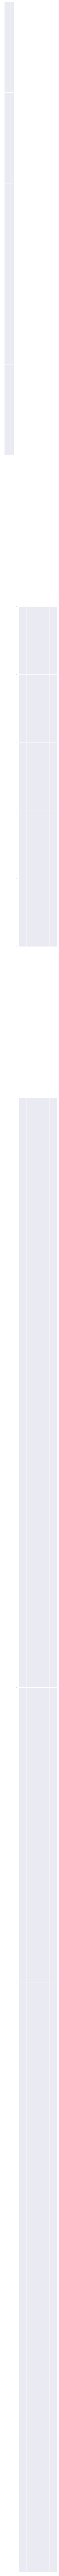

In [14]:
sns.set(font_scale=0.1)
sns.clustermap(
    rnaseq_tpm_plot[metadata.index.tolist()],
    z_score=0,
    row_cluster=True,
    col_cluster=False,
    center=0,
    cbar_kws={'label': 'Z-score'},
    col_colors=[
        sample_labels_wt.label,
        sample_labels_mct1.label,
        sample_labels_sit4.label,
        sample_labels_reg1.label,
        sample_labels_snf1.label],
    figsize=(4,200))

# Label legends
g = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles_g = [g("s", list(simp_sample_hex.values())[i]) for i in range(len(list(simp_sample_hex.values())))]
plt.legend(handles_g, list(simp_sample_hex.keys()), bbox_to_anchor=(11.75, 0.65), loc=2, borderaxespad=0., title='Samples')

#Save and show figure
plt.savefig(
    os.path.join(__path__, "plots", "rnaseq_protein_ALL_2021_02_10.pdf"),
    dpi=300,
    bbox_inches='tight')
plt.show()

In [15]:
gene_list_1 = [
    'VIP1',
    'PLC1',
    'PHO5',
    'VTC2',
    'PHO84',
    'PHO81',
    'VTC1',
    'VTC4',
    'VTC3',
    'PHO86',
    'PHO12',
    'PHO8',
    'IRC15',
    'CTF19'
]

gene_list_2 = [
    'CYC1',
    'NDE1',
    'MDH1',
    'ATP15',
    'POR1',
    'ATP3',
    'ATP2',
    'ATP18',
    'ATP19',
    'ACH1',
    'ATP17',
    'AIM33',
    'NDI1',
    'MIR1',
    'SEF1',
    'COX9',
    'COX5A',
    'CYT1',
    'PET9',
    'COX6',
    'COX7',
    'RIP1',
    'COX13',
    'INH1',
    'QCR7',
    'QCR8',
    'SDH2',
    'QCR9',
    'ATP14',
    'KGD2',
    'ATP4',
    'ATP20',
    'ATP5',
    'COX8',
    'COR1',
    'COX4',
    'ATP1',
    'ATP7',
    'QCR2',
    'ATP16',
    'MIC10',
    'LPD1',
    'MCR1',
    'KGD1',
    'AGX1',
    'GSM1',
    'RPM2',
    'SDH3',
    'QCR6',
    'QCR10',
    'COX12',
    'TIM11',
    'YPR010C-A'
]

simp_sample_hex = {
    'WT':   '#66c2a5', 
    'mct1': '#1b9e77',
    'sit4': '#8da0cb',
    'snf1': 'black'
}

In [16]:
metadata_noREG1 = metadata.loc[~metadata['Condition'].str.contains('reg1')]

rnaseq_tpm_set1 = rnaseq_tpm_named.copy()
rnaseq_tpm_set1.index = rnaseq_tpm_set1['common_name']
rnaseq_tpm_set1 = rnaseq_tpm_set1[metadata_noREG1.index.tolist()]
rnaseq_tpm_set1.index.name = None
rnaseq_tpm_set1 = rnaseq_tpm_set1.reindex(gene_list_1)

rnaseq_tpm_set2 = rnaseq_tpm_named.copy()
rnaseq_tpm_set2.index = rnaseq_tpm_set2['common_name']
rnaseq_tpm_set2 = rnaseq_tpm_set2[metadata_noREG1.index.tolist()]
rnaseq_tpm_set2.index.name = None
rnaseq_tpm_set2 = rnaseq_tpm_set2.reindex(gene_list_2)

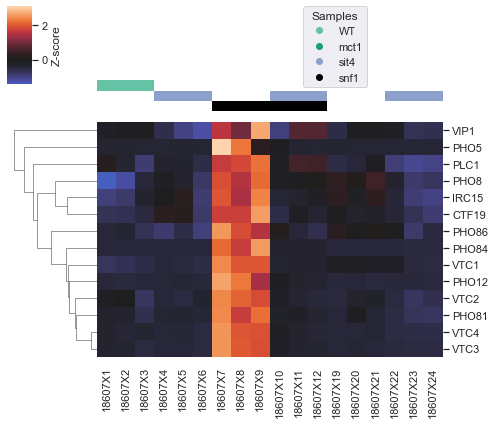

In [17]:
sns.set(font_scale=1)
sns.clustermap(
    rnaseq_tpm_set1,
    z_score=0,
    row_cluster=True,
    col_cluster=False,
    center=0,
    cbar_kws={'label': 'Z-score'},
    col_colors=[
        sample_labels_wt.label,
        sample_labels_mct1.label,
        sample_labels_sit4.label,
        sample_labels_snf1.label],
    figsize=(7,6))

# Label legends
g = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles_g = [g("s", list(simp_sample_hex.values())[i]) for i in range(len(list(simp_sample_hex.values())))]
plt.legend(handles_g, list(simp_sample_hex.keys()), bbox_to_anchor=(11.75, 1), loc=2, borderaxespad=0., title='Samples')

#Save and show figure
plt.savefig(
    os.path.join(__path__, "plots", "rnaseq_protein_geneset1_noREG1_2021_04_14.pdf"),
    dpi=300,
    bbox_inches='tight')
plt.show()

In [18]:
metadata_noREG1_noSNF1 = metadata.loc[
    ~metadata['Condition'].str.contains('reg1')
].loc[
    ~metadata['Condition'].str.contains('snf1')
].loc[
    ~metadata['Condition'].str.contains('sfn1')
]

rnaseq_tpm_set3 = rnaseq_tpm_named.copy()
rnaseq_tpm_set3.index = rnaseq_tpm_set3['common_name']
rnaseq_tpm_set3 = rnaseq_tpm_set3[metadata_noREG1_noSNF1.index.tolist()]
rnaseq_tpm_set3.index.name = None
rnaseq_tpm_set3 = rnaseq_tpm_set3.reindex(gene_list_1)

rnaseq_tpm_set4 = rnaseq_tpm_named.copy()
rnaseq_tpm_set4.index = rnaseq_tpm_set4['common_name']
rnaseq_tpm_set4 = rnaseq_tpm_set4[metadata_noREG1_noSNF1.index.tolist()]
rnaseq_tpm_set4.index.name = None
rnaseq_tpm_set4 = rnaseq_tpm_set4.reindex(gene_list_2)

In [19]:
simp_sample_hex = {
    'WT':   'black', 
    'mct1': '#8da0cb',
    'sit4': '#66c2a5'
}

In [20]:
sample_labels_wt = make_sample_labels(metadata, 'WT', simp_sample_hex, rnaseq_tpm)
sample_labels_mct1 = make_sample_labels(metadata, 'mct1', simp_sample_hex, rnaseq_tpm)
sample_labels_sit4 = make_sample_labels(metadata, 'sit4', simp_sample_hex, rnaseq_tpm)

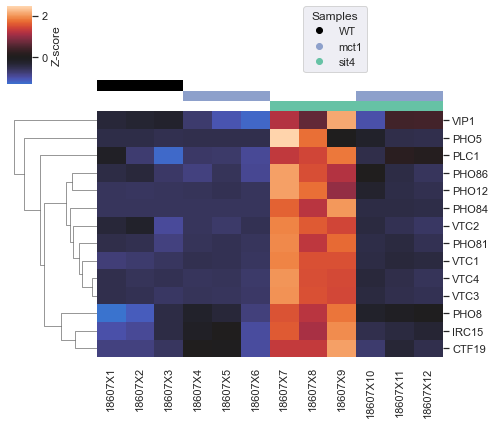

In [21]:
sns.set(font_scale=1)
sns.clustermap(
    rnaseq_tpm_set3,
    z_score=0,
    row_cluster=True,
    col_cluster=False,
    center=0,
    cbar_kws={'label': 'Z-score'},
    col_colors=[
        sample_labels_wt.label,
        sample_labels_mct1.label,
        sample_labels_sit4.label],
    figsize=(7,6))

# Label legends
g = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles_g = [g("s", list(simp_sample_hex.values())[i]) for i in range(len(list(simp_sample_hex.values())))]
plt.legend(handles_g, list(simp_sample_hex.keys()), bbox_to_anchor=(11.75, 1), loc=2, borderaxespad=0., title='Samples')

#Save and show figure
plt.savefig(
    os.path.join(__path__, "plots", "rnaseq_protein_geneset1_noREG1_noSNF1_2022_03_16.png"),
    dpi=1200,
    bbox_inches='tight')
plt.show()

In [22]:
np.log2((rnaseq_tpm_set3[["18607X10","18607X11","18607X12"]].sum(axis=1)/3) /
(rnaseq_tpm_set3[["18607X4","18607X5","18607X6"]].sum(axis=1)/3))

VIP1     0.211777
PLC1     0.194456
PHO5     1.000016
VTC2     0.041668
PHO84    1.883264
PHO81    0.095395
VTC1     0.226701
VTC4     0.229270
VTC3     0.556866
PHO86    0.197666
PHO12    1.310650
PHO8     0.125689
IRC15   -0.045508
CTF19   -0.200020
dtype: float64

In [23]:
np.log2((rnaseq_tpm_set3[["18607X7","18607X8","18607X9"]].sum(axis=1)/3) /
(rnaseq_tpm_set3[["18607X4","18607X5","18607X6"]].sum(axis=1)/3))

VIP1     0.477212
PLC1     0.565553
PHO5     4.378026
VTC2     0.898650
PHO84    5.487696
PHO81    1.340769
VTC1     1.783568
VTC4     1.908767
VTC3     3.173869
PHO86    0.860536
PHO12    4.396870
PHO8     0.626006
IRC15    1.159821
CTF19    1.181388
dtype: float64

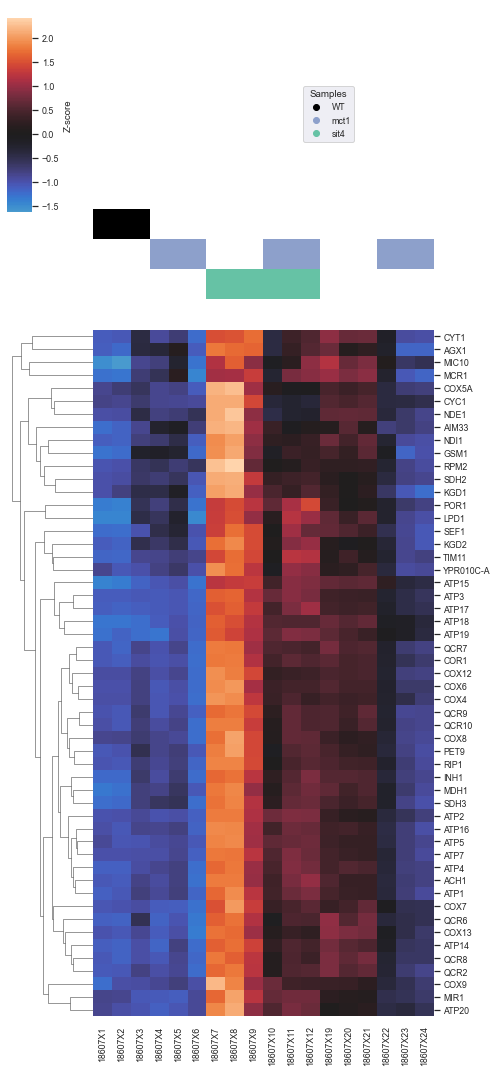

In [24]:
sns.set(font_scale=0.8)
sns.clustermap(
    rnaseq_tpm_set2,
    z_score=0,
    row_cluster=True,
    col_cluster=False,
    center=0,
    cbar_kws={'label': 'Z-score'},
    col_colors=[
        sample_labels_wt.label,
        sample_labels_mct1.label,
        sample_labels_sit4.label,
        sample_labels_snf1.label],
    figsize=(7,15))

# Label legends
g = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles_g = [g("s", list(simp_sample_hex.values())[i]) for i in range(len(list(simp_sample_hex.values())))]
plt.legend(handles_g, list(simp_sample_hex.keys()), bbox_to_anchor=(11.75, 0.65), loc=2, borderaxespad=0., title='Samples')

#Save and show figure
plt.savefig(
    os.path.join(__path__, "plots", "rnaseq_protein_geneset2_noREG1_2021_04_14.pdf"),
    dpi=300,
    bbox_inches='tight')
plt.show()

In [31]:
import os
import pandas as pd
import numpy as np
import scipy
from statsmodels.stats.multitest import multipletests
import xpressplot as xp
import matplotlib
import matplotlib.pyplot as plt
from numpy import mean, std
from math import sqrt
from scipy.stats import ttest_ind, sem
import scipy.stats as st
matplotlib.rc('font', family='arial')

def mean_confidence_interval(data, confidence=0.95):
    _interval = st.norm.interval(
        alpha=confidence,
        loc=np.mean(data),
        scale=st.sem(data)
    )
    return np.mean(data), _interval

def cohen_d(x,y):
    return (
        mean(x) - mean(y)) / sqrt((std(x, ddof=1) ** 2 + std(y, ddof=1) ** 2) / 2.0
    )

In [32]:
# WT vs SIT4

In [33]:
deseq_output = pd.read_csv(
    os.path.join(os.getcwd(), 'deseq_output_annotated', 'sit4_vs_WT_deseq2.tsv'),
    sep='\t',
    index_col=0
)

deseq_output.index = deseq_output['common_name']

de_dict = {}
for i, r in deseq_output.iterrows():
    fc = r['log2FoldChange']
    p = r['pvalue']
    pa = r['padj']
    if pa == np.nan:
        pa = 1
    if pa < 1E-50:
        pa = 1E-50
    if p == np.nan:
        p = 1
    if p < 1E-50:
        p = 1E-50
        
    de_dict[i] = [fc, p, pa]

In [34]:
metadata_sit4_wt = metadata.loc[(metadata['Condition'] == 'WT') | (metadata['Condition'] == 'sit4')]

exp = [
    '18607X7', #'sit4_1',
    '18607X8', #'sit4_1',
    '18607X9', #'sit4_3'
]

cont = [
    '18607X1', #'WT_1',
    '18607X2', #'WT_2',
    '18607X3', #'WT_3'
]

data_volcano = rnaseq_tpm_named.copy()
data_volcano.index = data_volcano['common_name']
data_volcano.index.name = None

for i, r in data_volcano.iterrows():
    
    data_volcano.at[i, 'log$_2$(Fold Change)'] = de_dict[i][0]
    data_volcano.at[i, 'pval'] = de_dict[i][1]
    data_volcano.at[i, 'FDR'] = de_dict[i][2]
    data_volcano.at[i, '-log$_1$$_0$(p-value)'] = -1 * np.log10(data_volcano.at[i, 'pval'])
    data_volcano.at[i, '-log$_1$$_0$(FDR)'] = -1 * np.log10(data_volcano.at[i, 'FDR'])
    
    
    data_volcano.at[i, 'Cohen\'s $\mathit{d}$'] = abs(
        cohen_d(
            data_volcano[exp].loc[i].values,
            data_volcano[cont].loc[i].values
        )
    )

    s1, s2 = mean_confidence_interval(
        data_volcano[exp].loc[i].values.tolist(),
        confidence=0.95)
    data_volcano.at[i, 'exp_mean'] = s1
    data_volcano.at[i, 'exp_ci95'] = str(s2)

    s1, s2 = mean_confidence_interval(
        data_volcano[cont].loc[i].values.tolist(),
        confidence=0.95)
    data_volcano.at[i, 'cont_mean'] = s1
    data_volcano.at[i, 'cont_ci95'] = str(s2)

C:\Users\jorda\AppData\Local\Temp\ipykernel_30632\4216570777.py:24: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\AppData\Local\Temp\ipykernel_30632\4216570777.py:24: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\AppData\Local\Temp\ipykernel_30632\4216570777.py:24: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jor

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning:

invalid value encountered in multiply


C:\Users\jorda\AppData\Local\Temp\ipykernel_30632\4216570777.py:24: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jor

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\AppData\Local\Temp\ipykernel_30632\4216570777.py:24: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jor

C:\Users\jorda\AppData\Local\Temp\ipykernel_30632\4216570777.py:24: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jor

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\AppData\Local\Temp\ipykernel_30632\4216570777.py:24: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\AppData\Local\Temp\ipykernel_30632\4216570777.py:24: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\jorda\miniconda3

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\AppData\Local\Temp\ipykernel_30632\4216570777.py:24: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jor

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\AppData\Local\Temp\ipykernel_30632\4216570777.py:24: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jor

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\AppData\Local\Temp\ipykernel_30632\4216570777.py:24: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning:

invalid value encountered in multiply

C:\Users\jorda\AppData\Local\Temp\ipykernel_30632\4216570777.py:24: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\jorda\miniconda3

In [27]:
data_volcano.to_csv(
    os.path.join(os.getcwd(), "output_tables", "volcano_data.txt"),
    sep='\t'
)

In [35]:
data_volcano_select1 = data_volcano.loc[gene_list_1]
data_volcano_select2 = data_volcano.loc[gene_list_2]

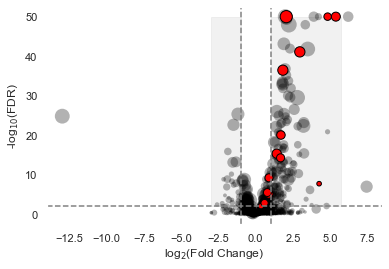

In [36]:
ax = plt.gca()
ax.set_facecolor('w')
data_volcano.plot.scatter(
    'log$_2$(Fold Change)', '-log$_1$$_0$(FDR)',
    c='black',
    edgecolors='none',
    s=data_volcano['Cohen\'s $\mathit{d}$'] * 10,
    alpha=0.3,
    grid=False,
    ax=ax)
data_volcano_select1.plot.scatter(
    'log$_2$(Fold Change)', '-log$_1$$_0$(FDR)',
    c='red',
    edgecolors='black',
    s=data_volcano_select1['Cohen\'s $\mathit{d}$'] * 10,
    alpha=1,
    grid=False,
    ax=ax)

l_box = matplotlib.patches.Rectangle((1,2), 4.75, 48, alpha=0.3, color="lightgrey", zorder=-10)
r_box = matplotlib.patches.Rectangle((-3,2), 2, 48, alpha=0.3, color="lightgrey", zorder=-10)
ax.add_patch(l_box)
ax.add_patch(r_box)
ax.axhline(2, ls='--', color="grey")
ax.axvline(-1, ls='--', color="grey")
ax.axvline(1, ls='--', color="grey")
# Save and show figure
plt.savefig(
    os.path.join(os.getcwd(), "plots", "volcano_plot_geneset1.pdf"),
    bbox_inches='tight'
)

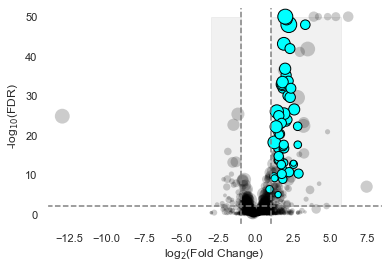

In [37]:
ax = plt.gca()
ax.set_facecolor('w')
data_volcano.plot.scatter(
    'log$_2$(Fold Change)', '-log$_1$$_0$(FDR)',
    c='black',
    edgecolors='none',
    s=data_volcano['Cohen\'s $\mathit{d}$'] * 10,
    alpha=0.2,
    grid=False,
    ax=ax)
data_volcano_select2.plot.scatter(
    'log$_2$(Fold Change)', '-log$_1$$_0$(FDR)',
    c='cyan',
    edgecolors='black',
    s=data_volcano_select2['Cohen\'s $\mathit{d}$'] * 10,
    alpha=1,
    grid=False,
    ax=ax)
l_box = matplotlib.patches.Rectangle((1,2), 4.75, 48, alpha=0.3, color="lightgrey", zorder=-10)
r_box = matplotlib.patches.Rectangle((-3,2), 2, 48, alpha=0.3, color="lightgrey", zorder=-10)
ax.add_patch(l_box)
ax.add_patch(r_box)
ax.axhline(2, ls='--', color="grey")
ax.axvline(-1, ls='--', color="grey")
ax.axvline(1, ls='--', color="grey")

# Save and show figure
plt.savefig(
    os.path.join(os.getcwd(), "plots", "volcano_plot_geneset2.pdf"),
    bbox_inches='tight'
)

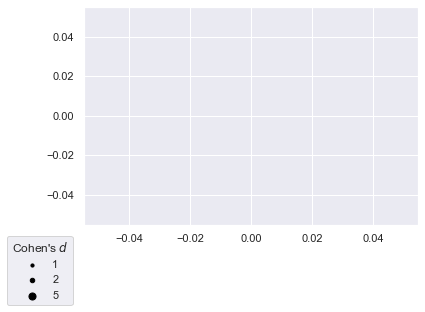

In [38]:
g1 = plt.scatter([],[], s=10, marker='o', color='black')
g2 = plt.scatter([],[], s=20, marker='o', color='black')
g3 = plt.scatter([],[], s=50, marker='o', color='black')
plt.legend(
    (g1, g2, g3),
    ['1', '2', '5'],
    bbox_to_anchor=(0, 0),
    loc=1, borderaxespad=1,
    title='Cohen\'s $\mathit{d}$')
plt.savefig(
    os.path.join(os.getcwd(), "plots", "volcano_plot_legend.pdf"),
    bbox_inches='tight'
)

<AxesSubplot:>

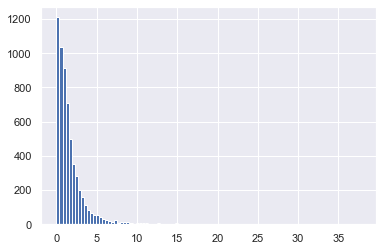

In [39]:
data_volcano['Cohen\'s $\mathit{d}$'].hist(bins=100)

In [40]:
exp = [
    '18607X7', #'sit4_1',
    '18607X8', #'sit4_1',
    '18607X9', #'sit4_3'
]

cont = [
    '18607X1', #'WT_1',
    '18607X2', #'WT_2',
    '18607X3', #'WT_3'
]

In [41]:
my_genes = rnaseq_tpm_named.loc[rnaseq_tpm_named["common_name"].isin(["PHO84", "SPL2"])]

In [42]:
np.log2(my_genes[exp].mean(axis=1) / my_genes[cont].mean(axis=1))

YHR136C    6.161845
YML123C    5.337337
dtype: float64

In [43]:
my_genes[exp + cont]

,18607X7,18607X8,18607X9,18607X1,18607X2,18607X3
YHR136C,291.516283,232.861073,240.604052,4.895021,3.07784,2.711556
YML123C,1495.444526,1228.323113,1732.577900,38.010203,35.43438,36.780441
